
image 1/1 /student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/images/test/video01_video01_28900_frame_28914_endo.png: 384x640 3 Livers, 15.0ms
Speed: 3.5ms preprocess, 15.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/results/segmentation-results/segmentation_test2
1 label saved to /student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/results/segmentation-results/segmentation_test2/labels


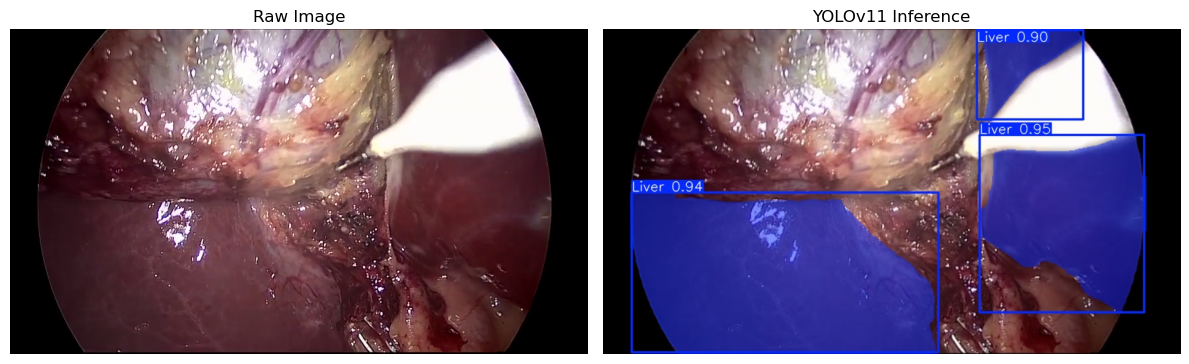

In [26]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# --- Load the trained model ---
model = YOLO("/student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/YOLO11/yolo-on-single-object-detection/weights/best.pt")

# --- Image path ---
image_path = "/student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/images/test/video01_video01_28900_frame_28914_endo.png"

# --- Custom save directory ---
project_dir = "/student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/results/segmentation-results"
exp_name = "segmentation_test"

# --- Run inference ---
results = model.predict(
    source=image_path,
    conf=0.25,
    save=True,
    save_txt=True,
    save_conf=True,
    project=project_dir,
    name=exp_name
)

# --- Locate predicted image ---
output_dir = os.path.join(project_dir, exp_name)
pred_image_path = None
for file in os.listdir(output_dir):
    if file.lower().endswith((".jpg", ".png")):
        pred_image_path = os.path.join(output_dir, file)
        break

if pred_image_path is None:
    raise FileNotFoundError(f"No prediction image found in: {output_dir}")

# --- Load images ---
raw_img = cv2.imread(image_path)
pred_img = cv2.imread(pred_image_path)

# --- Check if images were loaded ---
if raw_img is None:
    raise FileNotFoundError(f"Raw image not found: {image_path}")
if pred_img is None:
    raise FileNotFoundError(f"Predicted image not found: {pred_image_path}")

# --- Convert BGR to RGB ---
raw_img_rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
pred_img_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

# --- Display both images ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Raw Image")
plt.imshow(raw_img_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("YOLOv11 Inference")
plt.imshow(pred_img_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()


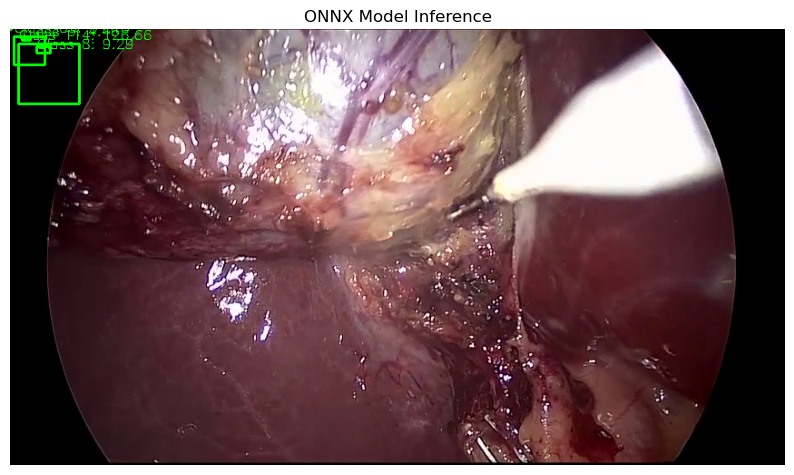

In [25]:
import onnxruntime as ort
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load the ONNX model ---
onnx_model_path = "/student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/YOLO11/yolo-on-single-object-detection/weights/quantization/best.onnx"
session = ort.InferenceSession(onnx_model_path)

# --- Load image ---
image_path = "/student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/images/test/video01_video01_28900_frame_28914_endo.png"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# --- Preprocess image ---
img_resized = cv2.resize(image, (640, 640))  # depends on your model's input size
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
img_normalized = img_rgb / 255.0
input_tensor = np.transpose(img_normalized, (2, 0, 1)).astype(np.float32)  # CHW
input_tensor = np.expand_dims(input_tensor, axis=0)  # Add batch dimension

# --- Run inference ---
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: input_tensor})

# --- Postprocess output ---
pred = outputs[0][0]  # Shape: [num_detections, 6]
boxes = pred[:, :4]
scores = pred[:, 4]
classes = pred[:, 5]

# --- Filter predictions ---
conf_threshold = 0.25
keep = scores > conf_threshold
boxes = boxes[keep]
scores = scores[keep]
classes = classes[keep]

# --- Rescale boxes to original image size ---
h, w = image.shape[:2]
scale_w, scale_h = w / 640, h / 640
boxes[:, [0, 2]] *= scale_w
boxes[:, [1, 3]] *= scale_h
boxes = boxes.astype(np.int32)

# --- Draw boxes ---
for box, score, cls in zip(boxes, scores, classes):
    x1, y1, x2, y2 = box
    label = f"Class {int(cls)}: {score:.2f}"
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# --- Convert to RGB for display ---
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- Show image ---
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("ONNX Model Inference")
plt.show()
